<a href="https://colab.research.google.com/github/mongrelDS/time-series-study/blob/main/Nairobi_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

part 1 wrangling data from source

part 2 autoregressive models

part 3 arma and hypermarameter tuning


In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pytz

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from os import rename

In [90]:
def wrangle(files):
  df=pd.read_csv(
      files,
      delimiter=';', 
      index_col= 5
      )
    
  #Localize timezone
  df.index = pd.to_datetime(df.index)
  df.index= df.index.tz_convert("Africa/Nairobi")

  # Use rows where sensor id == 162 and reading type is P2. Remove all PS values above 500
  df=df[(df['sensor_id']==162) & (df['value_type']=='P2') & (df['value'] <500) ][['value']]

  # Label (rename) value column as P2
  df.rename(columns = {'value':'P2'}, inplace = True)

  # Resample to 1H and ffill missing values
  df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()

  # add lag
  df["P2.L1"]= df["P2"].shift(1)
    
  #drop nan
  df.dropna(inplace=True)
    
  return df



In [91]:
files = '/content/drive/MyDrive/Public Data Projects/Air Quality Index/Nairobi/april_2021_sensor_data_archive.csv'
wrangle(files)

,P2,P2.L1
timestamp,,
2021-04-16 13:00:00+03:00,22.600000,22.600000
2021-04-16 14:00:00+03:00,11.770000,22.600000
2021-04-16 15:00:00+03:00,8.868182,11.770000
2021-04-16 16:00:00+03:00,7.289583,8.868182
2021-04-16 17:00:00+03:00,7.108696,7.289583
...,...,...
2021-04-20 07:00:00+03:00,14.416667,10.102174
2021-04-20 08:00:00+03:00,18.543333,14.416667
2021-04-20 09:00:00+03:00,21.734783,18.543333


In [92]:
df.head()

,P2,P2.L1
timestamp,,
2022-06-14 07:26:21.720672+00:00,14.0,8.6
2022-06-14 07:26:53.713341+00:00,15.0,14.0
2022-06-14 07:28:55.732831+00:00,11.0,15.0
2022-06-14 07:29:27.688800+00:00,14.0,11.0
2022-06-14 07:29:59.588716+00:00,16.5,14.0


In [93]:
df.info

<bound method DataFrame.info of                                     P2  P2.L1
timestamp                                    
2022-06-14 07:26:21.720672+00:00  14.0    8.6
2022-06-14 07:26:53.713341+00:00  15.0   14.0
2022-06-14 07:28:55.732831+00:00  11.0   15.0
2022-06-14 07:29:27.688800+00:00  14.0   11.0
2022-06-14 07:29:59.588716+00:00  16.5   14.0
...                                ...    ...
2022-06-30 23:57:50.618994+00:00   5.0    3.8
2022-06-30 23:58:22.311606+00:00   3.0    5.0
2022-06-30 23:58:54.069403+00:00   5.0    3.0
2022-06-30 23:59:26.618124+00:00   4.0    5.0
2022-06-30 23:59:58.374073+00:00   4.4    4.0

[44129 rows x 2 columns]>

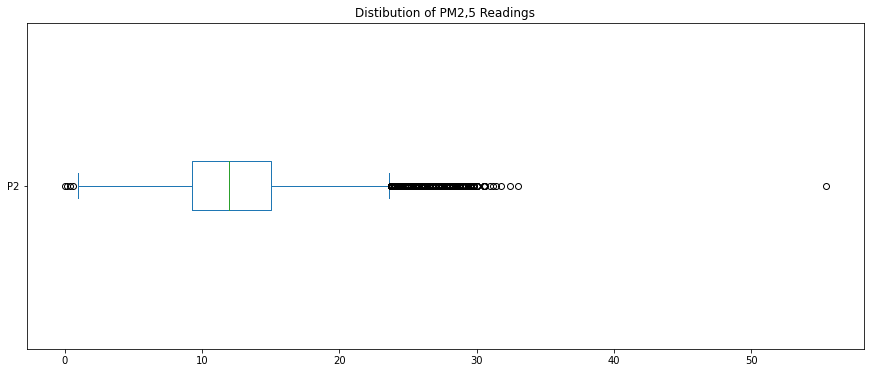

In [94]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(kind="box",vert=False, title="Distibution of PM2,5 Readings", ax=ax)

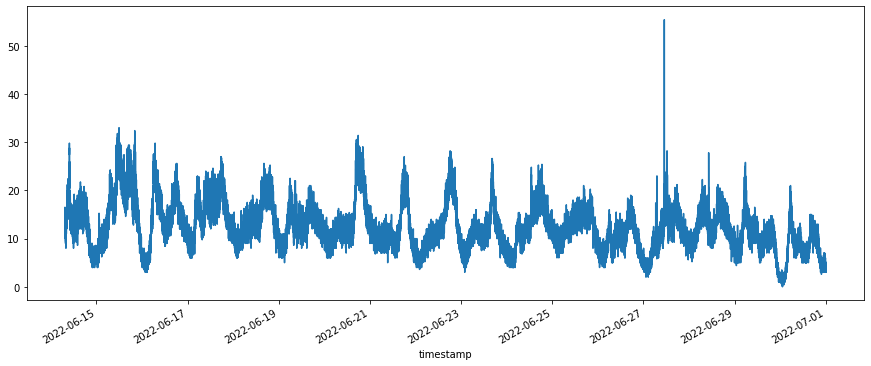

In [95]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot()

In [96]:
df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()

,P2
timestamp,
2022-06-14 07:00:00+00:00,12.745082
2022-06-14 08:00:00+00:00,14.971364
2022-06-14 09:00:00+00:00,19.698148
2022-06-14 10:00:00+00:00,14.503302
2022-06-14 11:00:00+00:00,12.067453
...,...
2022-06-30 19:00:00+00:00,9.693694
2022-06-30 20:00:00+00:00,6.809524
2022-06-30 21:00:00+00:00,4.780088


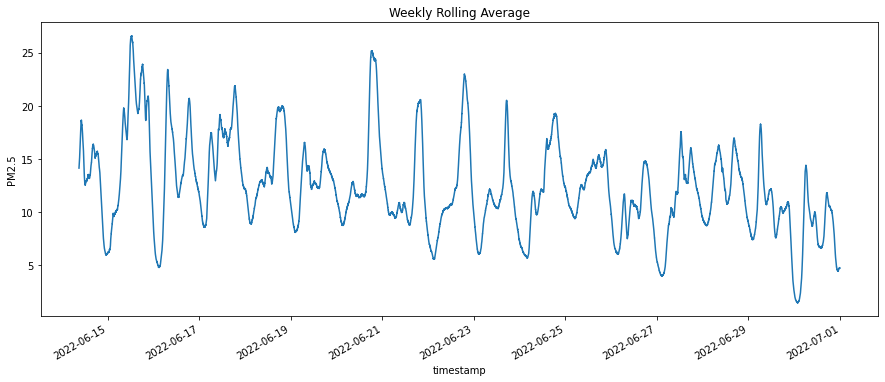

In [97]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].rolling(168).mean().plot(ax=ax, ylabel="PM2.5", title="Weekly Rolling Average")

In [98]:
"""
create a column called "P2.L1" that contains the mean"P2" reading from the previous hour. 
Since this new feature will create NaN values in your DataFrame, be sure to also drop null rows from df

"""
df["P2.L1"]= df["P2"].shift(1) 
df.dropna(inplace=True)
df.corr()

,P2,P2.L1
P2,1.000000,0.916692
P2.L1,0.916692,1.000000


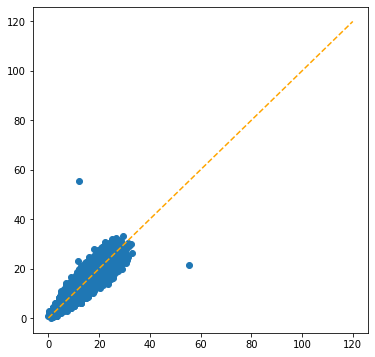

In [99]:
"""

 Create a scatter plot that shows PM 2.5 mean reading for each our as a function of the mean reading from the previous hour.
  In other words, "P2.L1" should be on the x-axis, and "P2" should be on the y-axis. Don't forget to label your axes!

"""


fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0,120],[0,120], linestyle="--",color="orange")
ax.scatter(x=df["P2.L1"], y=df["P2"])

In [100]:
"""
Split the DataFrame df into the feature matrix X and the target vector y. Your target is "P2".

"""

target = "P2"
y = df[target]
X = df.drop(columns=target)
X.head()

,P2.L1
timestamp,
2022-06-14 07:26:53.713341+00:00,14.0
2022-06-14 07:28:55.732831+00:00,15.0
2022-06-14 07:29:27.688800+00:00,11.0
2022-06-14 07:29:59.588716+00:00,14.0
2022-06-14 07:30:31.464635+00:00,16.5


In [101]:
"""
Split X and y into training and test sets. 
The first 80% of the data should be in your training set. 
The remaining 20% should be in the test set.

"""
cutoff = int(len(X)*0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]


# Model

In [102]:
"""
Baseline
Calculate the baseline mean absolute error for your model.

"""

y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)

mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 12.87
Baseline MAE: 3.71


In [103]:
"""
Iterate
Instantiate a LinearRegression model named model, and fit it to your training data.

"""

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [104]:
"""
Evaluate
Calculate the training and test mean absolute error for your model.

"""

training_mae = mean_absolute_error(y_train,model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))


Training MAE: 1.49
Test MAE: 1.32


# Communicate Results

In [105]:

"""
Extract the intercept and coefficient from your model.
"""

intercept = model.intercept_
coefficient = model.coef_

print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

P2 = 1.1062319334527828 + ([0.91407546] * P2.L1)


In [106]:
"""
Create a DataFrame df_pred_test that has two columns: "y_test" and "y_pred".
The first should contain the true values for your test set, and the second should contain your model's predictions. 
Be sure the index of df_pred_test matches the index of y_test.

"""

df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred": model.predict(X_test)
        
    }


)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2022-06-27 15:27:29.837066+00:00,12.0,12.989213
2022-06-27 15:28:08.333060+00:00,13.0,12.075137
2022-06-27 15:28:40.433083+00:00,11.6,12.989213
2022-06-27 15:29:19.385024+00:00,13.0,11.709507
2022-06-27 15:29:51.449368+00:00,11.0,12.989213


In [107]:
"""
 Create a time series line plot for the values in test_predictions using plotly express. 
 Be sure that the y-axis is properly labeled as "P2".
"""

fig = px.line(df_pred_test, labels={"value":"P2"})
fig.show()

In [107]:
y = wrangle(nairobi)
y.head()